1650.csv :maxFreq: 1648.3483516713045
1660.csv :maxFreq: 1649.9967000163988
1670.csv :maxFreq: 1651.6483483581674
1680.csv :maxFreq: 1696.6033930970832
1690.csv :maxFreq: 1698.2983015747932
1700.csv :maxFreq: 1696.6033932439464
1710.csv :maxFreq: 1698.29830172195
1720.csv :maxFreq: 1697.450424463974
1730.csv :maxFreq: 1598.398401620659
1740.csv :maxFreq: 1599.1972013490638
1750.csv :maxFreq: 1600.7971986814728
1760.csv :maxFreq: 1596.0067831431795
1770.csv :maxFreq: 1599.996800015902
1780.csv :maxFreq: 1596.8031936413613
1790.csv :maxFreq: 1601.5983984079198
1800.csv :maxFreq: 1546.9030938400688
1810.csv :maxFreq: 1550.7722860881015
1820.csv :maxFreq: 1553.1031062154425
1830.csv :maxFreq: 1547.675386877232
1840.csv :maxFreq: 1549.9969000154051
1850.csv :maxFreq: 1550.7722862226767


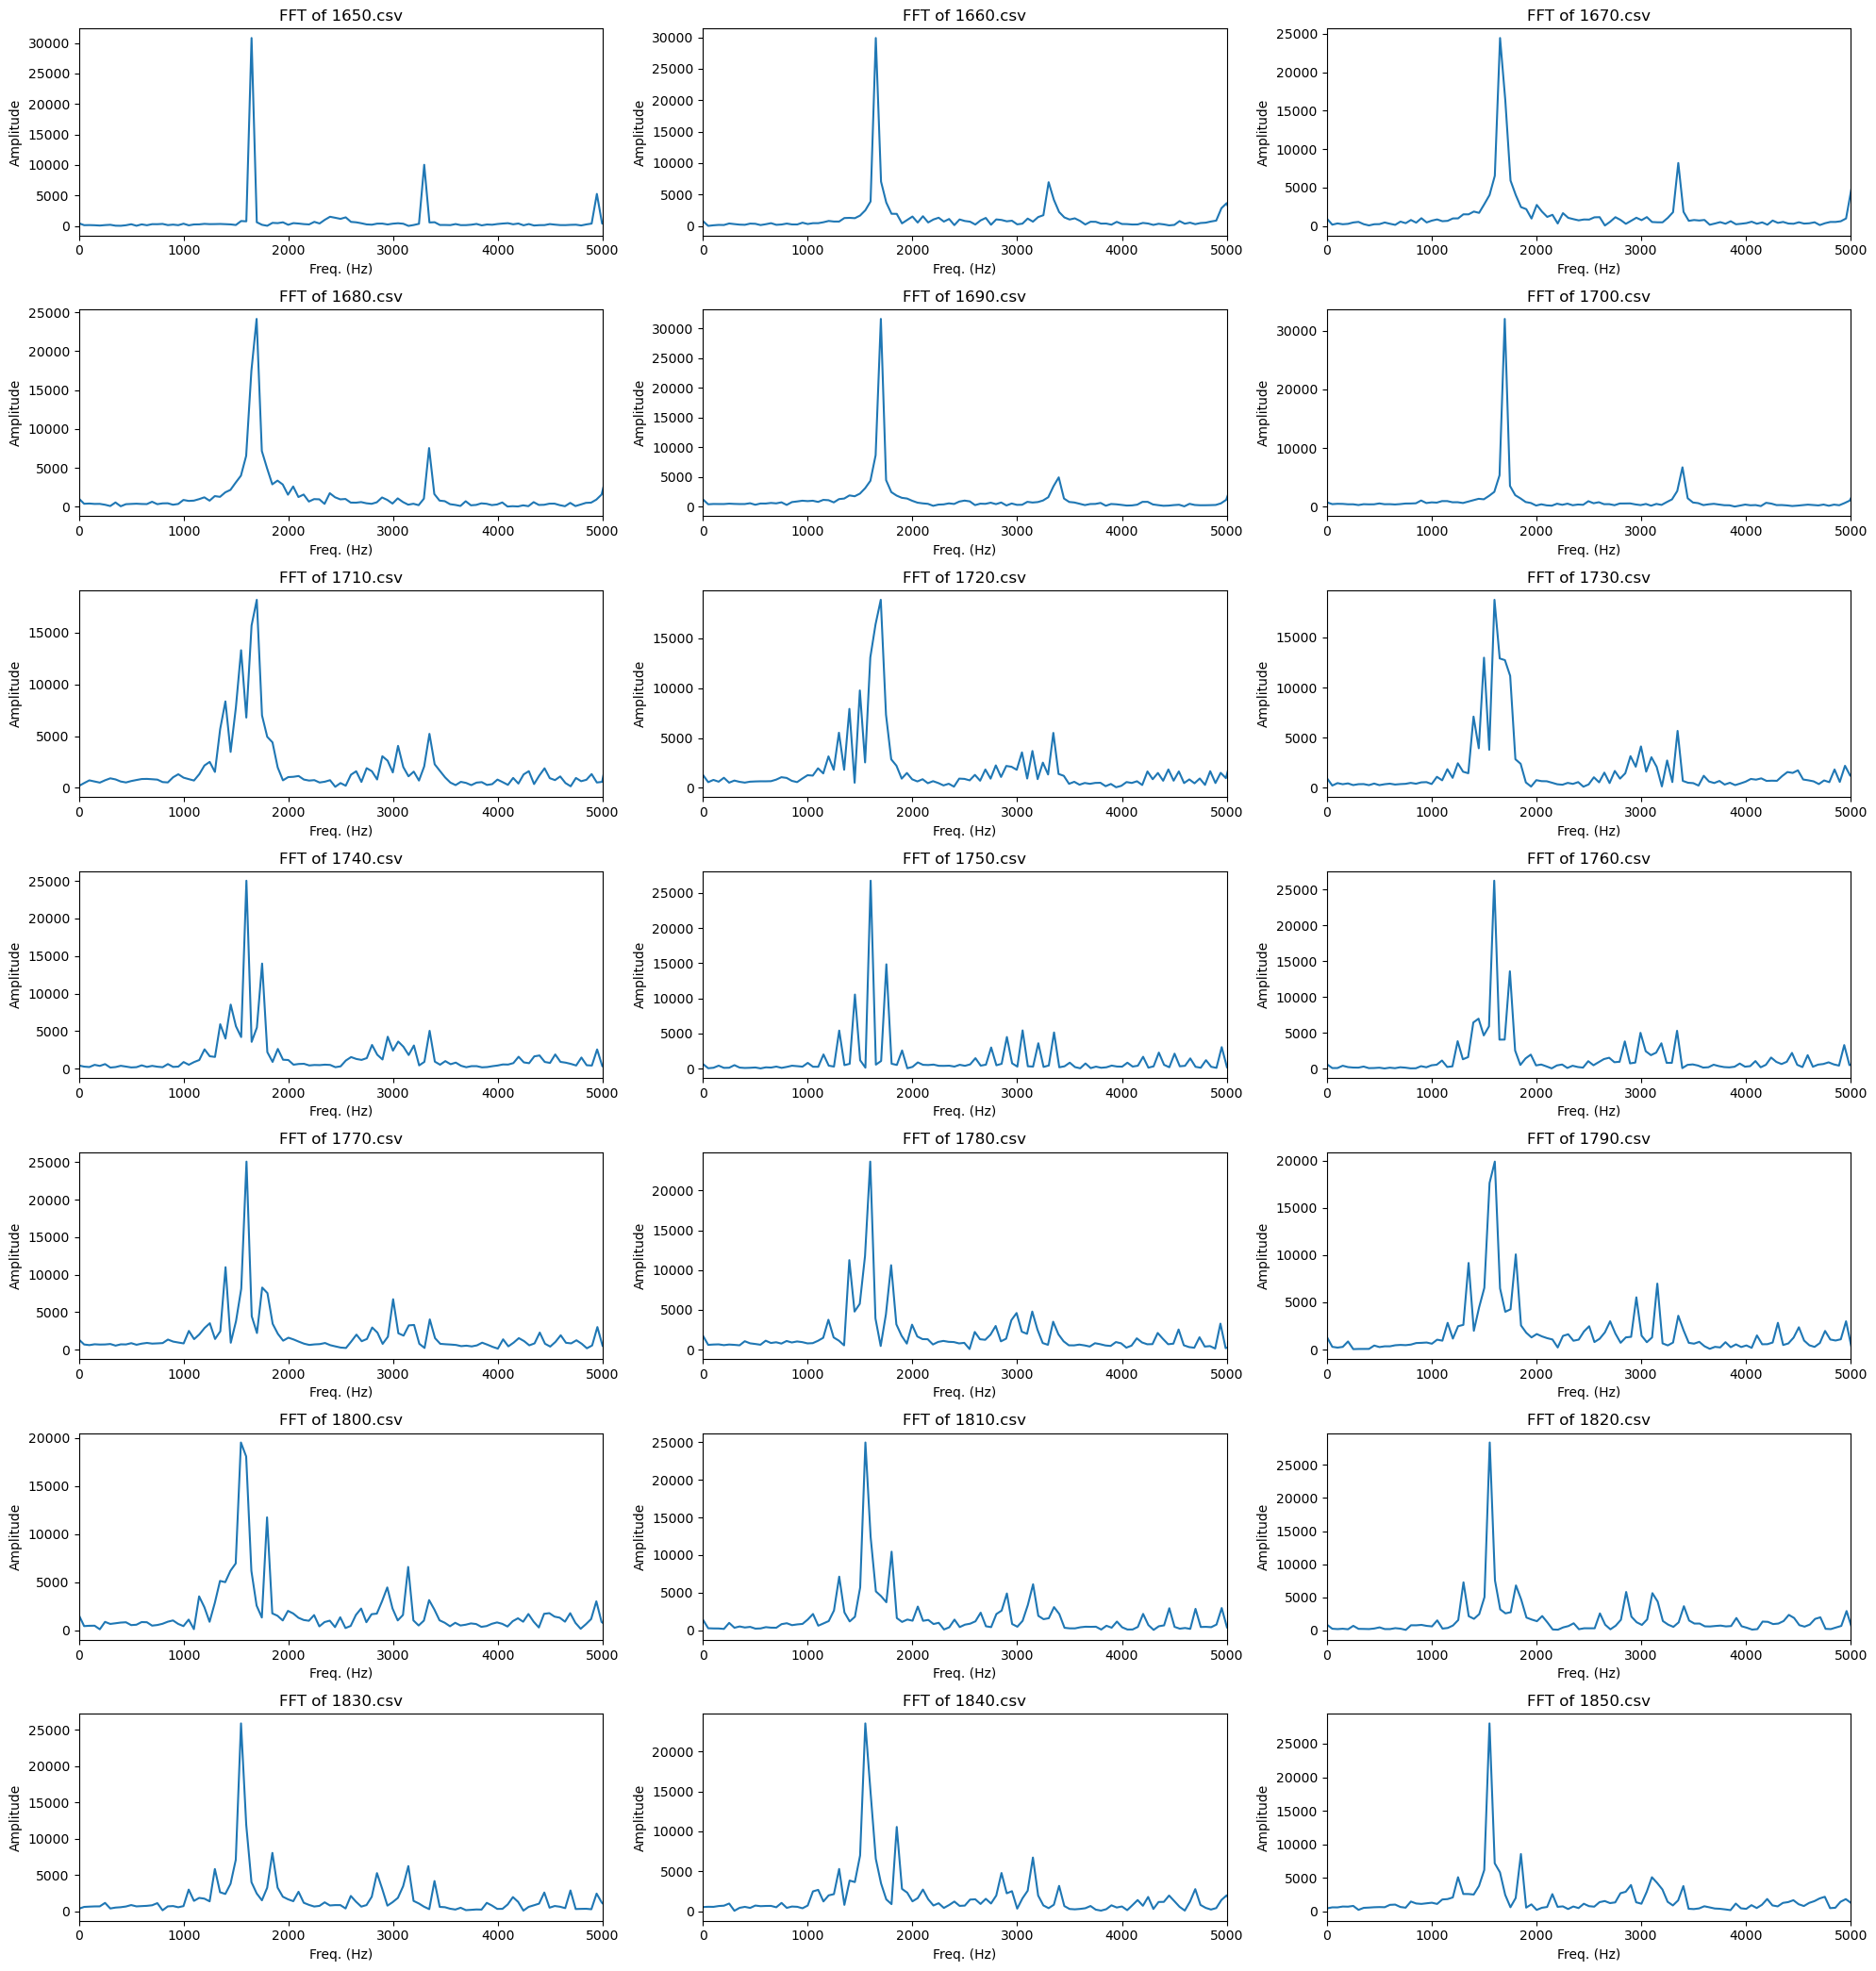

In [1]:
## << 파일별 주파수 응답 >> ##

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt



def find_indices_within_tolerance(column, target_value, tolerance):
    # 열(column)과 목표 값(target_value), 오차(tolerance)가 주어짐
    column = np.array(column)  # 리스트나 시리즈를 numpy 배열로 변환
    differences = np.abs(column - target_value)  # 각 성분과 목표 값의 차이 절댓값 계산
    indices = np.where(differences <= tolerance)[0]  # 차이가 tolerance 이내인 인덱스 추출
    return indices


def convert_k_to_float(value):
    if 'k' in value:
        return float(value.replace('k', '')) * 1.e3
    elif 'm' in value:
        return float(value.replace('m', '')) * 1.e-3
    else:
        return float(value)



targetFreq=[]
targetAmp=[]


# CSV 파일 목록 가져오기 (파일명 예: '5k.csv', '10k.csv', ...)
file_list = glob.glob('*.csv')  # 현재 폴더의 모든 CSV 파일 목록 가져오기
file_list.sort()  # 파일명 순으로 정렬 (5k, 10k, ... 순서로 정렬되도록)

# subplot 배열 설정
num_files = len(file_list)
cols = 3  # 열 개수
rows = (num_files + cols - 1) // cols  # 필요한 행 개수 계산

plt.figure(figsize=(20, rows * 3))  # 전체 subplot 크기 설정

# 각 파일에 대해 FFT 수행 및 서브플롯 그리기
for i, file in enumerate(file_list):
    # CSV 파일 읽기 (첫 4개의 행을 건너뜀)
    data = pd.read_csv(file, skiprows=4)
    
    # Time과 Amplitude 데이터 추출
    time = data['Time']
    amplitude = data['Ampl']
    
    
    # FFT 수행
    N = len(amplitude)
    fftamp = np.fft.fft(amplitude)
    dt = time.iloc[1] - time.iloc[0]  # 시간 간격
    freq = np.fft.fftfreq(N, dt)
    
    # 절반 구간만 사용 (양수 주파수만)
    fftamp = np.abs(fftamp)[:N // 2]
    freq = freq[:N // 2]

    print(file,':maxFreq:',freq[np.argmax(fftamp)])


    # FFT 결과를 서브플롯에 그리기
    plt.subplot(rows, cols, i + 1)
    plt.plot(freq, fftamp)
    plt.xlim(0, 5000)
    plt.title(f"FFT of {file}")
    plt.xlabel("Freq. (Hz)")
    plt.ylabel("Amplitude")

plt.tight_layout()  # subplot 간격 조정
plt.show()



 외부진동수 VS FFT


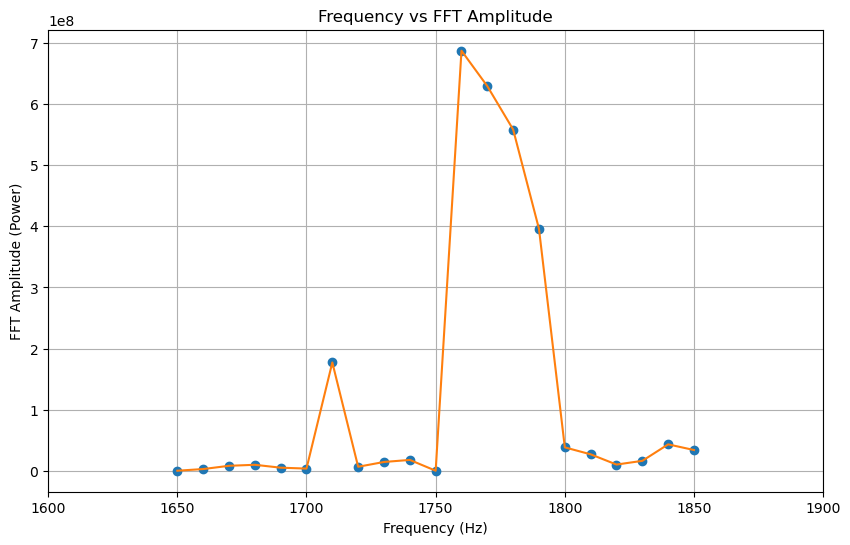

maxamp: 687330728.055494 maxfreq: 1760.0
데이터 내보내기 완료


In [15]:
## << 주파수 응답 살펴보기 & 응답 파일 내보내기>> ##


import pickle
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

extfreq=[]
extfft=[]

def find_indices_within_tolerance(column, target_value, tolerance):
    # 열(column)과 목표 값(target_value), 오차(tolerance)가 주어짐
    column = np.array(column)  # 리스트나 시리즈를 numpy 배열로 변환
    differences = np.abs(column - target_value)  # 각 성분과 목표 값의 차이 절댓값 계산
    indices = np.where(differences <= tolerance)[0]  # 차이가 tolerance 이내인 인덱스 추출
    return indices

def convert_k_to_float(value):
    # 파일명에서 '.csv'를 제거하고 'k'가 포함된 경우 처리
    value = value.replace('.csv', '')
    if 'k' in value:
        return float(value.replace('k', '')) * 1.e3
    elif 'm' in value:
        return float(value.replace('m', '')) * 1.e-3
    else:
        return float(value)
    
# CSV 파일 목록 가져오기 (파일명 예: '5k.csv', '10k.csv', ...)
file_list = glob.glob('*.csv')  # 현재 폴더의 모든 CSV 파일 목록 가져오기
file_list.sort()  # 파일명 순으로 정렬 (5k, 10k, ... 순서로 정렬되도록)


# 파일명 목록 출력
#print("현재 디렉토리의 파일명 목록과 그에 대응하는 외부 진동수:")
external_freqs = []  # 파일명에서 추출한 외부 진동수 목록
target_fft_amps = []  # 각 파일의 외부 진동수에서의 FFT 값 목록
for file in file_list:
    # 파일명에서 외부 진동수 추출 (예: '5k.csv' -> 5000)
    external_freq = convert_k_to_float(file.split('k')[0])
    external_freqs.append(external_freq)

    # CSV 파일 읽기 (첫 4개의 행을 건너뜀)
    data = pd.read_csv(file, skiprows=4)
    
    # Time과 Amplitude 데이터 추출
    time = data['Time']
    amplitude = data['Ampl']
    
    # FFT 수행
    N = len(amplitude)
    fftamp = np.fft.fft(amplitude)
    dt = time.iloc[1] - time.iloc[0]  # 시간 간격
    freq = np.fft.fftfreq(N, dt)
    
    # 절반 구간만 사용 (양수 주파수만)
    fftamp = (fftamp * np.conj(fftamp))[:N // 2].real
    # normal=1.e5
    # fftamp = fftamp/normal
    freq = freq[:N // 2]

    # 외부 진동수에 해당하는 FFT 값 추출
    indices_within_tolerance = find_indices_within_tolerance(freq, external_freq, tolerance=200)
    
    if len(indices_within_tolerance) > 0:
        closest_index = indices_within_tolerance[0]
        target_fft_amps.append(fftamp[closest_index])
    else:
        # 가장 가까운 주파수 값을 사용하여 NaN 대신 값을 할당
        closest_index = np.argmin(np.abs(freq - external_freq))
        target_fft_amps.append(fftamp[closest_index])  # 찾지 못한 경우 NaN으로 설정하여 식별 가능하도록 수정

# 파일명과 그에 대응하는 FFT 값을 출력
print("\n 외부진동수 VS FFT")
for file, freq, fft_amp in zip(file_list, external_freqs, target_fft_amps):
    #print(f"파일명: {file}, 진동수: {freq} Hz, FFT 값: {fft_amp}")
    extfreq.append(float(freq))
    extfft.append(float(fft_amp))


# 진동수를 가로축, FFT 값을 세로축으로 하는 피겨 생성
plt.figure(figsize=(10, 6))
plt.plot(extfreq, extfft, 'o')
plt.plot(extfreq, extfft, '-')
plt.xlabel("Frequency (Hz)")
# plt.ylabel(f"FFT Amplitude (Power)[{normal}]")
plt.ylabel("FFT Amplitude (Power)")
plt.title("Frequency vs FFT Amplitude")
plt.grid(True)
plt.xlim(1600,1900)
plt.show()
print('maxamp:',max(extfft),'maxfreq:',extfreq[np.argmax(extfft)])



    ##파일쓰기 & 내보내기

fft_data = {}
fft_data['x'] = extfreq
fft_data['y'] = extfft


with open('fft400mV.pickle', 'wb') as f:
    pickle.dump(fft_data, f, pickle.HIGHEST_PROTOCOL)


print('데이터 내보내기 완료')

C:\Users\jipyeong\AppData\Local\Temp\ipykernel_18776\4156778883.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


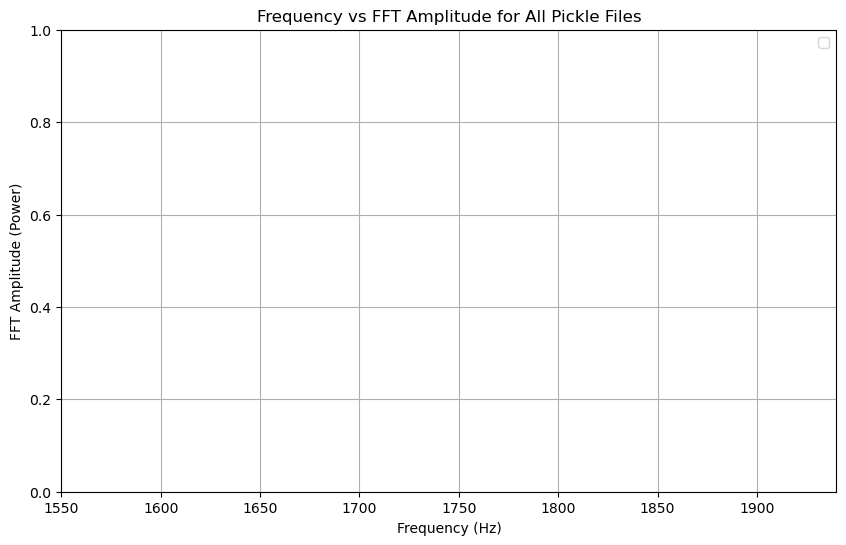

In [ ]:
## 모든 응답 파일 오버랩 ##


import pickle
import matplotlib.pyplot as plt
import glob

# 현재 디렉토리의 모든 피클 파일 찾기
pickle_files = glob.glob("*.pickle")

# 모든 피클 데이터를 저장할 리스트
all_data = []

# 피클 파일 읽기
for file in pickle_files:
    with open(file, 'rb') as f:
        try:
            data = pickle.load(f)
            all_data.append((file, data))  # 파일 이름과 데이터를 저장
        except Exception as e:
            print(f"Error reading {file}: {e}")

# 스캐터 플롯 그리기
plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # 사용할 색상 목록
for i, (file_name, data) in enumerate(all_data):
    color = colors[i % len(colors)]  # 색상을 순환하여 사용
    plt.scatter(data['x'], data['y'], label=file_name, c=color)
    plt.plot(data['x'], data['y'], c=color)

plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT Amplitude (Power)")
plt.title("Frequency vs FFT Amplitude for All Pickle Files")
plt.grid(True)
plt.xlim(1550, 1940)
plt.legend()
plt.show()
